# Диагностика оттока клиентов

Отток клиентов - критически важный показатель для любого бизнеса, особенно в высококонкурентной телекоммуникационной отрасли. Понимание причин ухода клиентов и выявление факторов, способствующих оттоку, может помочь компаниям разработать стратегии по удержанию клиентов, тем самым повышая прибыльность и удовлетворенность клиентов.

В этом блокноте мы анализируем набор данных Telecom Customers Churn, предоставленный компанией IBM, который содержит различные демографические, учетные и связанные с обслуживанием атрибуты клиентов за определенный период времени. Исследуя эти переменные, мы стремимся выявить закономерности и ключевые индикаторы оттока клиентов. Благодаря сочетанию анализа категориальных и числовых данных, а также корреляции и исследования важности признаков, этот анализ позволит получить сведения, которые могут стать основой для разработки целевых стратегий удержания клиентов и прогнозных моделей.

## 0) Импорт модулей Python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## 1) Загрузка данных.

In [2]:
df = pd.read_csv("Telecom Customers Churn.csv")

## 2) Предобработка данных

In [3]:
df.info()
print(df.describe())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Общие расходы не представлены в числовых данных, и мы знаем из метаданных, что для пожилого человека 0 = Нет и 1 = Да, поэтому мы преобразуем их:

In [4]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['SeniorCitizen'] = df['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})

Есть ли дублированные или пустые значения?

In [5]:
print("Number of duplicated values: ",df.duplicated().sum())
print("\nNull values: ")
df.isnull().sum()

Number of duplicated values:  0

Null values: 


customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [6]:
df[df["TotalCharges"].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,No,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,No,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


Мы не знаем, как заполнить эти недостающие суммарные расходы, поэтому отбрасываем эти строки:

In [7]:
df.dropna(subset=['TotalCharges'], inplace=True)

In [8]:
# Сводная статистика для числовых столбцов
numerical_summary = df.describe()
print(numerical_summary)

# Сводная статистика для категориальных столбцов
categorical_summary = df.describe(include=['object'])
print(categorical_summary)

            tenure  MonthlyCharges  TotalCharges
count  7032.000000     7032.000000   7032.000000
mean     32.421786       64.798208   2283.300441
std      24.545260       30.085974   2266.771362
min       1.000000       18.250000     18.800000
25%       9.000000       35.587500    401.450000
50%      29.000000       70.350000   1397.475000
75%      55.000000       89.862500   3794.737500
max      72.000000      118.750000   8684.800000
        customerID gender SeniorCitizen Partner Dependents PhoneService  \
count         7032   7032          7032    7032       7032         7032   
unique        7032      2             2       2          2            2   
top     7590-VHVEG   Male            No      No         No          Yes   
freq             1   3549          5890    3639       4933         6352   

       MultipleLines InternetService OnlineSecurity OnlineBackup  \
count           7032            7032           7032         7032   
unique             3               3           

## 3) Анализ целевой переменной (отток).

Для начала давайте разберемся, как распределяется Churn:

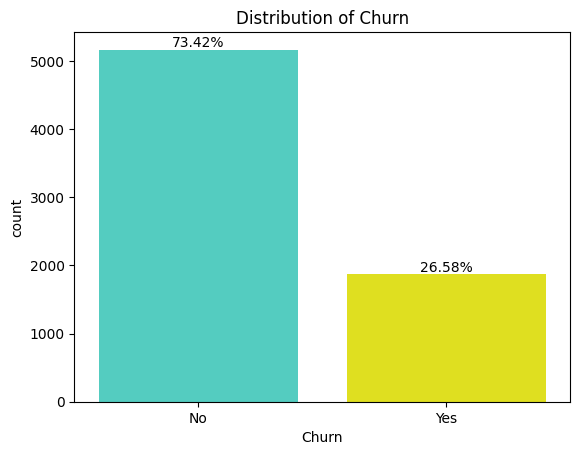

Churn
No     73.421502
Yes    26.578498
Name: proportion, dtype: float64


In [9]:
# Распределение переменной оттока
colors1= ['turquoise', 'yellow']
ax = sns.countplot(x='Churn', palette=colors1, data=df, hue='Churn')

# Рассчитать процент каждого значения
total_count = len(df)
for p in ax.patches:
    height = p.get_height()
    if height > 0:  #Избегать аннотирования пустых столбцов
        ax.annotate(f'{height/total_count:.2%}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom')

plt.title('Distribution of Churn')
plt.show()

# Уровень оттока
churn_rate = df['Churn'].value_counts(normalize=True) * 100
print(churn_rate)

Мы наблюдаем, что **1 из каждых 4 клиентов был потерян** в этом месяце. Это большая проблема, поэтому нам нужно определить переменные, которые могут быть связаны с этим явлением:

## 4) Визуализации и статистические тесты

Давайте погрузимся глубже и изучим отток по различным **категориальным переменным**:

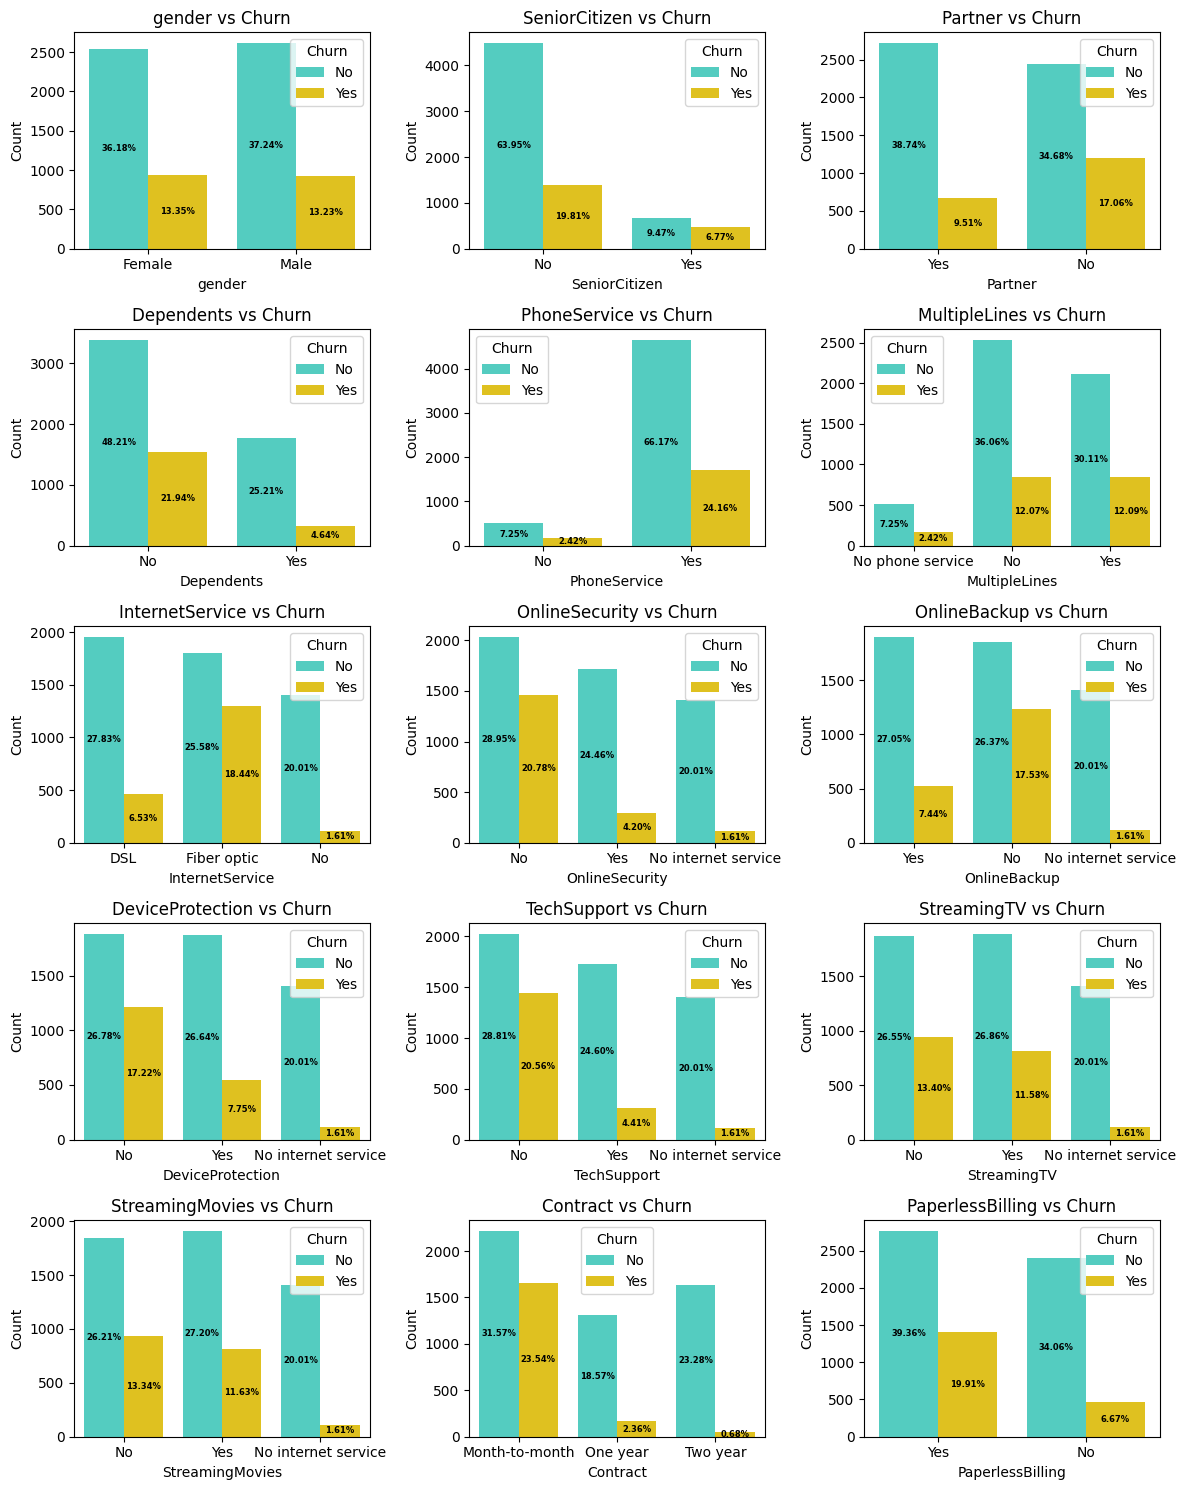

In [10]:
# Список категориальных переменных
categorical_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                    'Contract', 'PaperlessBilling']

# Количество колонок для сетки подграфиков
n_cols = 3
n_rows = (len(categorical_vars) + n_cols - 1) // n_cols  # Рассчитываем количество строк

# Создаем подграфики
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 3))  # Настраиваем размер фигуры

# Выравниваем массив осей для удобной итерации
axes = axes.flatten()

# Определяем палитру цветов
palette = ['#40E0D0', '#FFD700']  # Бирюзовый и желтый

# Итерация по переменным и создание count plot
for i, var in enumerate(categorical_vars):
    sns.countplot(x=var, hue='Churn', palette=palette, data=df, ax=axes[i])
    axes[i].set_title(f'{var} vs Churn')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')
    # Рассчитываем процент каждого значения
    total_count = len(df)
    for p in axes[i].patches:
        height = p.get_height()
        if height > 0:  # Избегаем аннотирования пустых столбцов
            axes[i].annotate(f'{height/total_count:.2%}', (p.get_x() + p.get_width() / 2., height / 2),
                            # ha='center', va='bottom')
                             ha='center', va='center', color='black', fontsize=6, weight='bold')
# Удаляем пустые подграфики (если есть)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

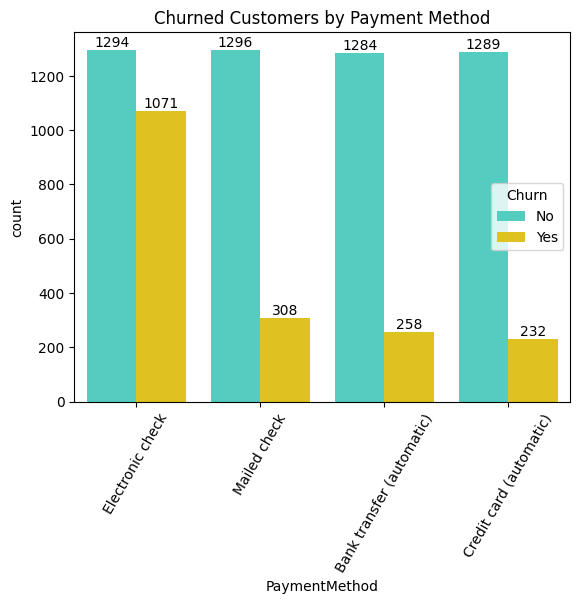

In [11]:
# Создание графика
ax = sns.countplot(x="PaymentMethod", hue="Churn", data=df, palette=["#40E0D0", "#FFD700"])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.title("Churned Customers by Payment Method")
plt.xticks(rotation=60)
plt.show()

### <u>Информация о категориальных переменных и оттоке: </u>
- **Пол** не оказывает существенного влияния на отток (результаты статистических тестов оказались незначительными). Однако **пожилые люди**, по-видимому, более склонны к оттоку.
- Клиенты, не имеющие **партнеров или иждивенцев**, имеют более высокий процент оттока.
- **Телефонное обслуживание** и **Многочисленные линии**, похоже, не связаны с оттоком (результаты не были значимыми).
- Клиенты с более продвинутыми **интернет-услугами** (оптоволокно > DSL > отсутствие интернета), похоже, чаще отказываются от услуг.
- Контракты, в которых отсутствуют **Онлайн-безопасность, онлайн-резервное копирование, защита устройств или техническая поддержка**, имеют более высокий процент отказов.
- Клиенты с более длительными сроками **контракта** менее склонны к оттоку.
- Клиенты с более современными вариантами **биллинга** и **оплаты**, похоже, чаще отказываются от услуг.

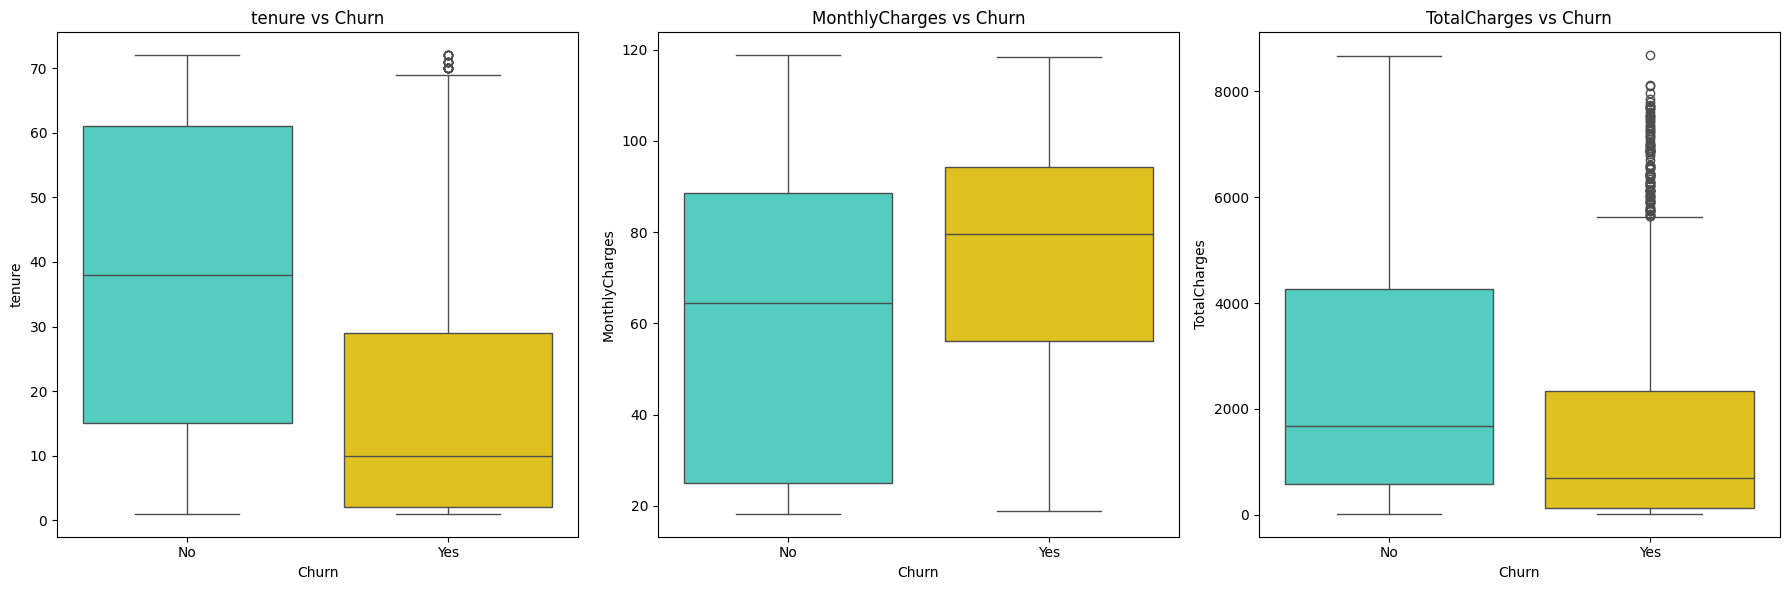

In [12]:
# Список числовых переменных
numerical_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']
# Создание подграфиков
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# Цветовая палитра
colors1 = ["#40E0D0", "#FFD700"]
# Построение графиков
for ax, var in zip(axes, numerical_vars):
    sns.boxplot(x='Churn', y=var, palette=colors1, hue='Churn', data=df, ax=ax)
    ax.set_title(f'{var} vs Churn')
plt.tight_layout()
plt.show()

In [13]:
num_tests = len(numerical_vars)
alpha = 0.05  # Desired significance level
bonferroni_alpha = alpha / num_tests  # Adjusted significance level

# Тесты хи-квадрат с коррекцией Бонферрони (так как мы выполняем несколько тестов)
for var in categorical_vars:
    contingency_table = pd.crosstab(df[var], df['Churn'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    print(f'Chi-square test for {var}: p-value = {p}')
    print(f'Bonferroni corrected p-value = {p * num_tests}')
    if p < bonferroni_alpha:
        print(f'Result for {var} is significant after Bonferroni correction.')
        print('\n')
    else:
        print(f'Result for {var} is not significant after Bonferroni correction.')
        print('\n')

Chi-square test for gender: p-value = 0.490488470706551
Bonferroni corrected p-value = 1.4714654121196529
Result for gender is not significant after Bonferroni correction.


Chi-square test for SeniorCitizen: p-value = 2.4792557203954705e-36
Bonferroni corrected p-value = 7.437767161186411e-36
Result for SeniorCitizen is significant after Bonferroni correction.


Chi-square test for Partner: p-value = 3.97379757451591e-36
Bonferroni corrected p-value = 1.192139272354773e-35
Result for Partner is significant after Bonferroni correction.


Chi-square test for Dependents: p-value = 2.0196592017051303e-42
Bonferroni corrected p-value = 6.058977605115391e-42
Result for Dependents is significant after Bonferroni correction.


Chi-square test for PhoneService: p-value = 0.34992398942431924
Bonferroni corrected p-value = 1.0497719682729576
Result for PhoneService is not significant after Bonferroni correction.


Chi-square test for MultipleLines: p-value = 0.0035679273999811405
Bonferroni corr

Тесты хи-квадрат с коррекцией Бонферрони используются для проверки значимости связи между категориальными переменными и оттоком клиентов (Churn).

список переменных, которые значимы и не значимы после коррекции Бонферрони:

Значимые переменные:
SeniorCitizen (Пожилой гражданин)
Partner (Партнер)
Dependents (Иждивенцы)
InternetService (Интернет-сервис)
OnlineSecurity (Онлайн-безопасность)
OnlineBackup (Онлайн-резервное копирование)
DeviceProtection (Защита устройства)
TechSupport (Техническая поддержка)
StreamingTV (Потоковое ТВ)
StreamingMovies (Потоковые фильмы)
Contract (Контракт)
PaperlessBilling (Безбумажное выставление счетов)
PaymentMethod (Способ оплаты)


Не значимые переменные:
Gender (Пол)
PhoneService (Телефонная служба)
MultipleLines (Множественные линии)

In [14]:
# Результаты статистических тестов
results = []

for var in numerical_vars:
    churned = df[df['Churn'] == 'Yes'][var].dropna()
    not_churned = df[df['Churn'] == 'No'][var].dropna()

    # Выполнить Mann-Whitney U test
    u_stat, p_val = mannwhitneyu(churned, not_churned, alternative='two-sided')
    results.append((var, u_stat, p_val))
    print(f'Mann-Whitney U test for {var}: U-statistic = {u_stat:.4f}, p-value = {p_val:.4f}')

# Применить коррекцию Бонферрони
num_tests = len(numerical_vars)
alpha = 0.05
bonferroni_alpha = alpha / num_tests

print(f'\nBonferroni corrected significance level = {bonferroni_alpha:.4f}')

for var, u_stat, p_val in results:
    corrected_p_val = min(p_val * num_tests, 1.0)  # Убедиться, что p-значение не превышает 1
    print(f'{var} - Uncorrected p-value: {p_val:.4f}, Corrected p-value: {corrected_p_val:.4f}')
    if corrected_p_val < bonferroni_alpha:
        print(f'Result for {var} is significant after Bonferroni correction.')
        print('\n')
    else:
        print(f'Result for {var} is not significant after Bonferroni correction.')
        print('\n')

Mann-Whitney U test for tenure: U-statistic = 2494979.0000, p-value = 0.0000
Mann-Whitney U test for MonthlyCharges: U-statistic = 5986148.5000, p-value = 0.0000
Mann-Whitney U test for TotalCharges: U-statistic = 3360665.0000, p-value = 0.0000

Bonferroni corrected significance level = 0.0167
tenure - Uncorrected p-value: 0.0000, Corrected p-value: 0.0000
Result for tenure is significant after Bonferroni correction.


MonthlyCharges - Uncorrected p-value: 0.0000, Corrected p-value: 0.0000
Result for MonthlyCharges is significant after Bonferroni correction.


TotalCharges - Uncorrected p-value: 0.0000, Corrected p-value: 0.0000
Result for TotalCharges is significant after Bonferroni correction.




Тест Манна-Уитни: Этот непараметрический тест используется для сравнения двух независимых выборок (в данном случае, клиентов, которые ушли, и тех, которые остались) по числовым переменным. Он проверяет, есть ли статистически значимые различия в распределении значений между этими группами.

Вывод: Все три числовые переменные (tenure, MonthlyCharges и TotalCharges) имеют значимое влияние на отток клиентов, что подтверждается тестом Манна-Уитни и коррекцией Бонферрони. Это означает, что различия в этих переменных между клиентами, которые остаются, и теми, которые уходят, статистически значимы.

### <u>Извлечения из числовых переменных и отток: </u>
- Более низкий **tenure**, по-видимому, связан с повышенной вероятностью оттока клиентов.
- Более высокие MonthlyCharge**Ежемесячные расходы**, по-видимому, связаны с оттоком клиентов, в то время как TotalCharges **Общие расходы** также демонстрируют аналогичную тенденцию: более низкие значения связаны с оттоком.


## 5) Сегменты клиентов с высоким риском

Мы проведем **сегментационный анализ**, чтобы выяснить, кто из клиентов подвержен высокому риску оттока:

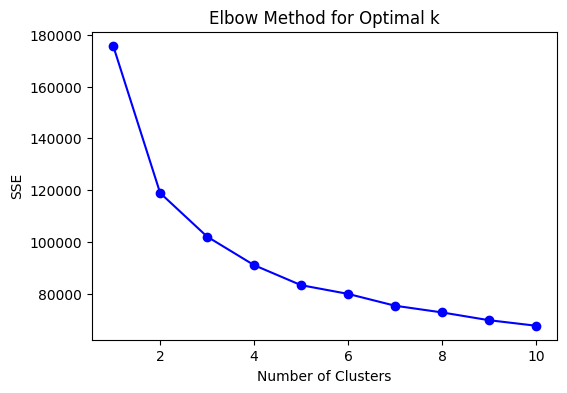

In [15]:
#  Выбор признаков для кластеризации
features = df[['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'InternetService', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport',
                    'Contract', 'PaperlessBilling', 'PaymentMethod']]

# Преобразование категориальных переменных в числовые (One-Hot Encoding)
features = pd.get_dummies(features, drop_first=True)

# Стандартизация признаков
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Определение оптимального количества кластеров с использованием метода локтя
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

# Построение кривой локтя
plt.figure(figsize=(6, 4))
plt.plot(k_range, sse, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')
plt.show()

In [16]:
# Выбор оптимального количества кластеров (на основе метода локтя) и настройка K-Means
optimal_k = 9 # найдено из графика
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
df['Segment'] = kmeans.fit_predict(scaled_features)

# Анализ уровня оттока в каждом сегменте
segment_analysis = df.groupby('Segment')['Churn'].value_counts(normalize=True).unstack().fillna(0)
print(segment_analysis)

Churn          No       Yes
Segment                    
0        0.878241  0.121759
1        0.414858  0.585142
2        0.964504  0.035496
3        0.689349  0.310651
4        0.992101  0.007899
5        0.425220  0.574780
6        0.767970  0.232030
7        0.904132  0.095868
8        0.808933  0.191067


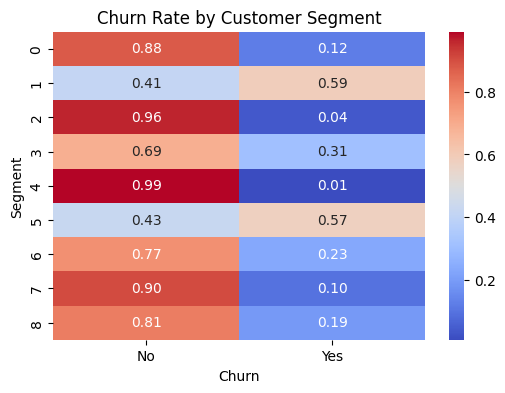

In [17]:
# Построение характеристик сегментов и уровней оттока
plt.figure(figsize=(6, 4))
sns.heatmap(segment_analysis, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Churn Rate by Customer Segment')
plt.show()

Мы выявили 4 кластера клиентов с высоким процентом оттока (номера **1, 3, 5 и 6**). Давайте опишем их с помощью визуализации:

C:\Users\user\AppData\Local\Temp\ipykernel_1696\1099967224.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Segment', y=feature, data=df[df['Segment'].isin(all_segments)], palette='coolwarm', ax=axes[i])
C:\Users\user\AppData\Local\Temp\ipykernel_1696\1099967224.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Segment', y=feature, data=df[df['Segment'].isin(all_segments)], palette='coolwarm', ax=axes[i])
C:\Users\user\AppData\Local\Temp\ipykernel_1696\1099967224.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplo

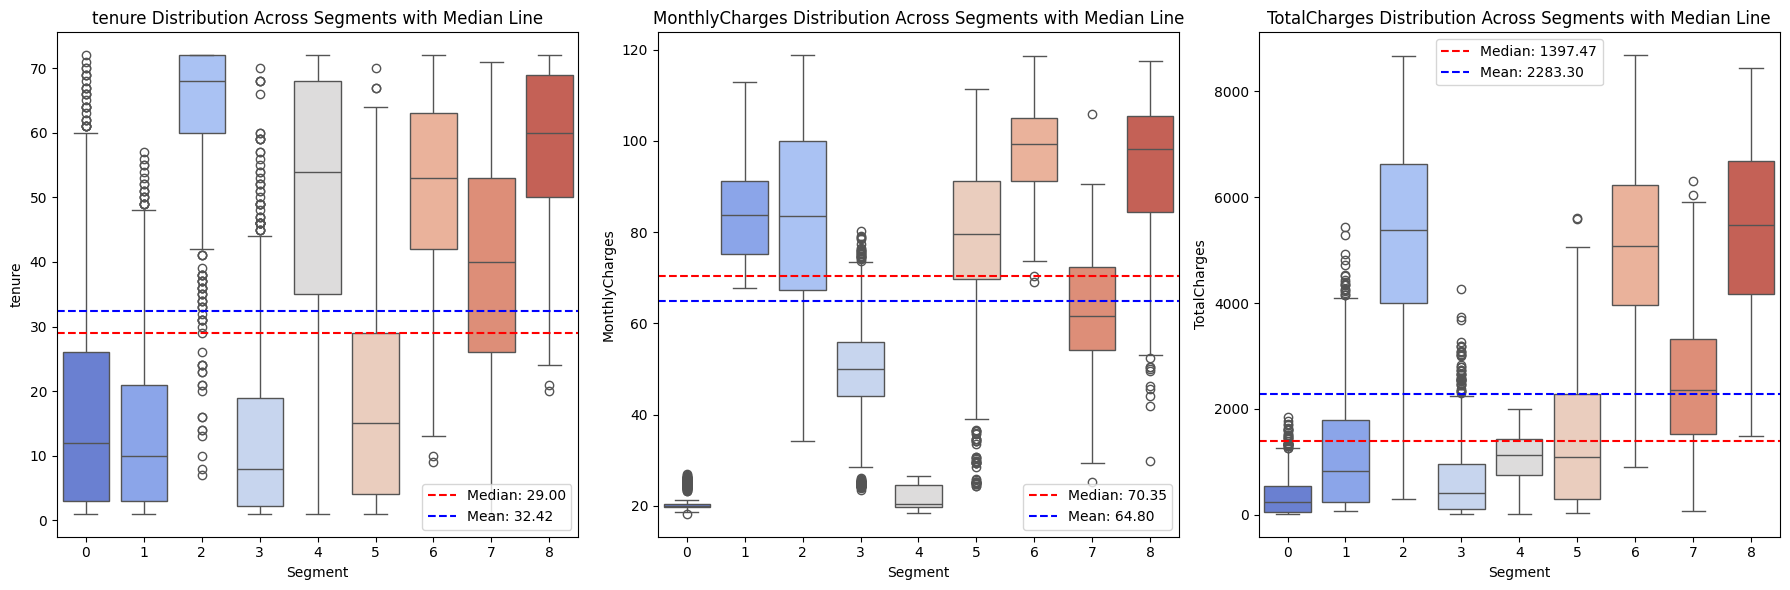

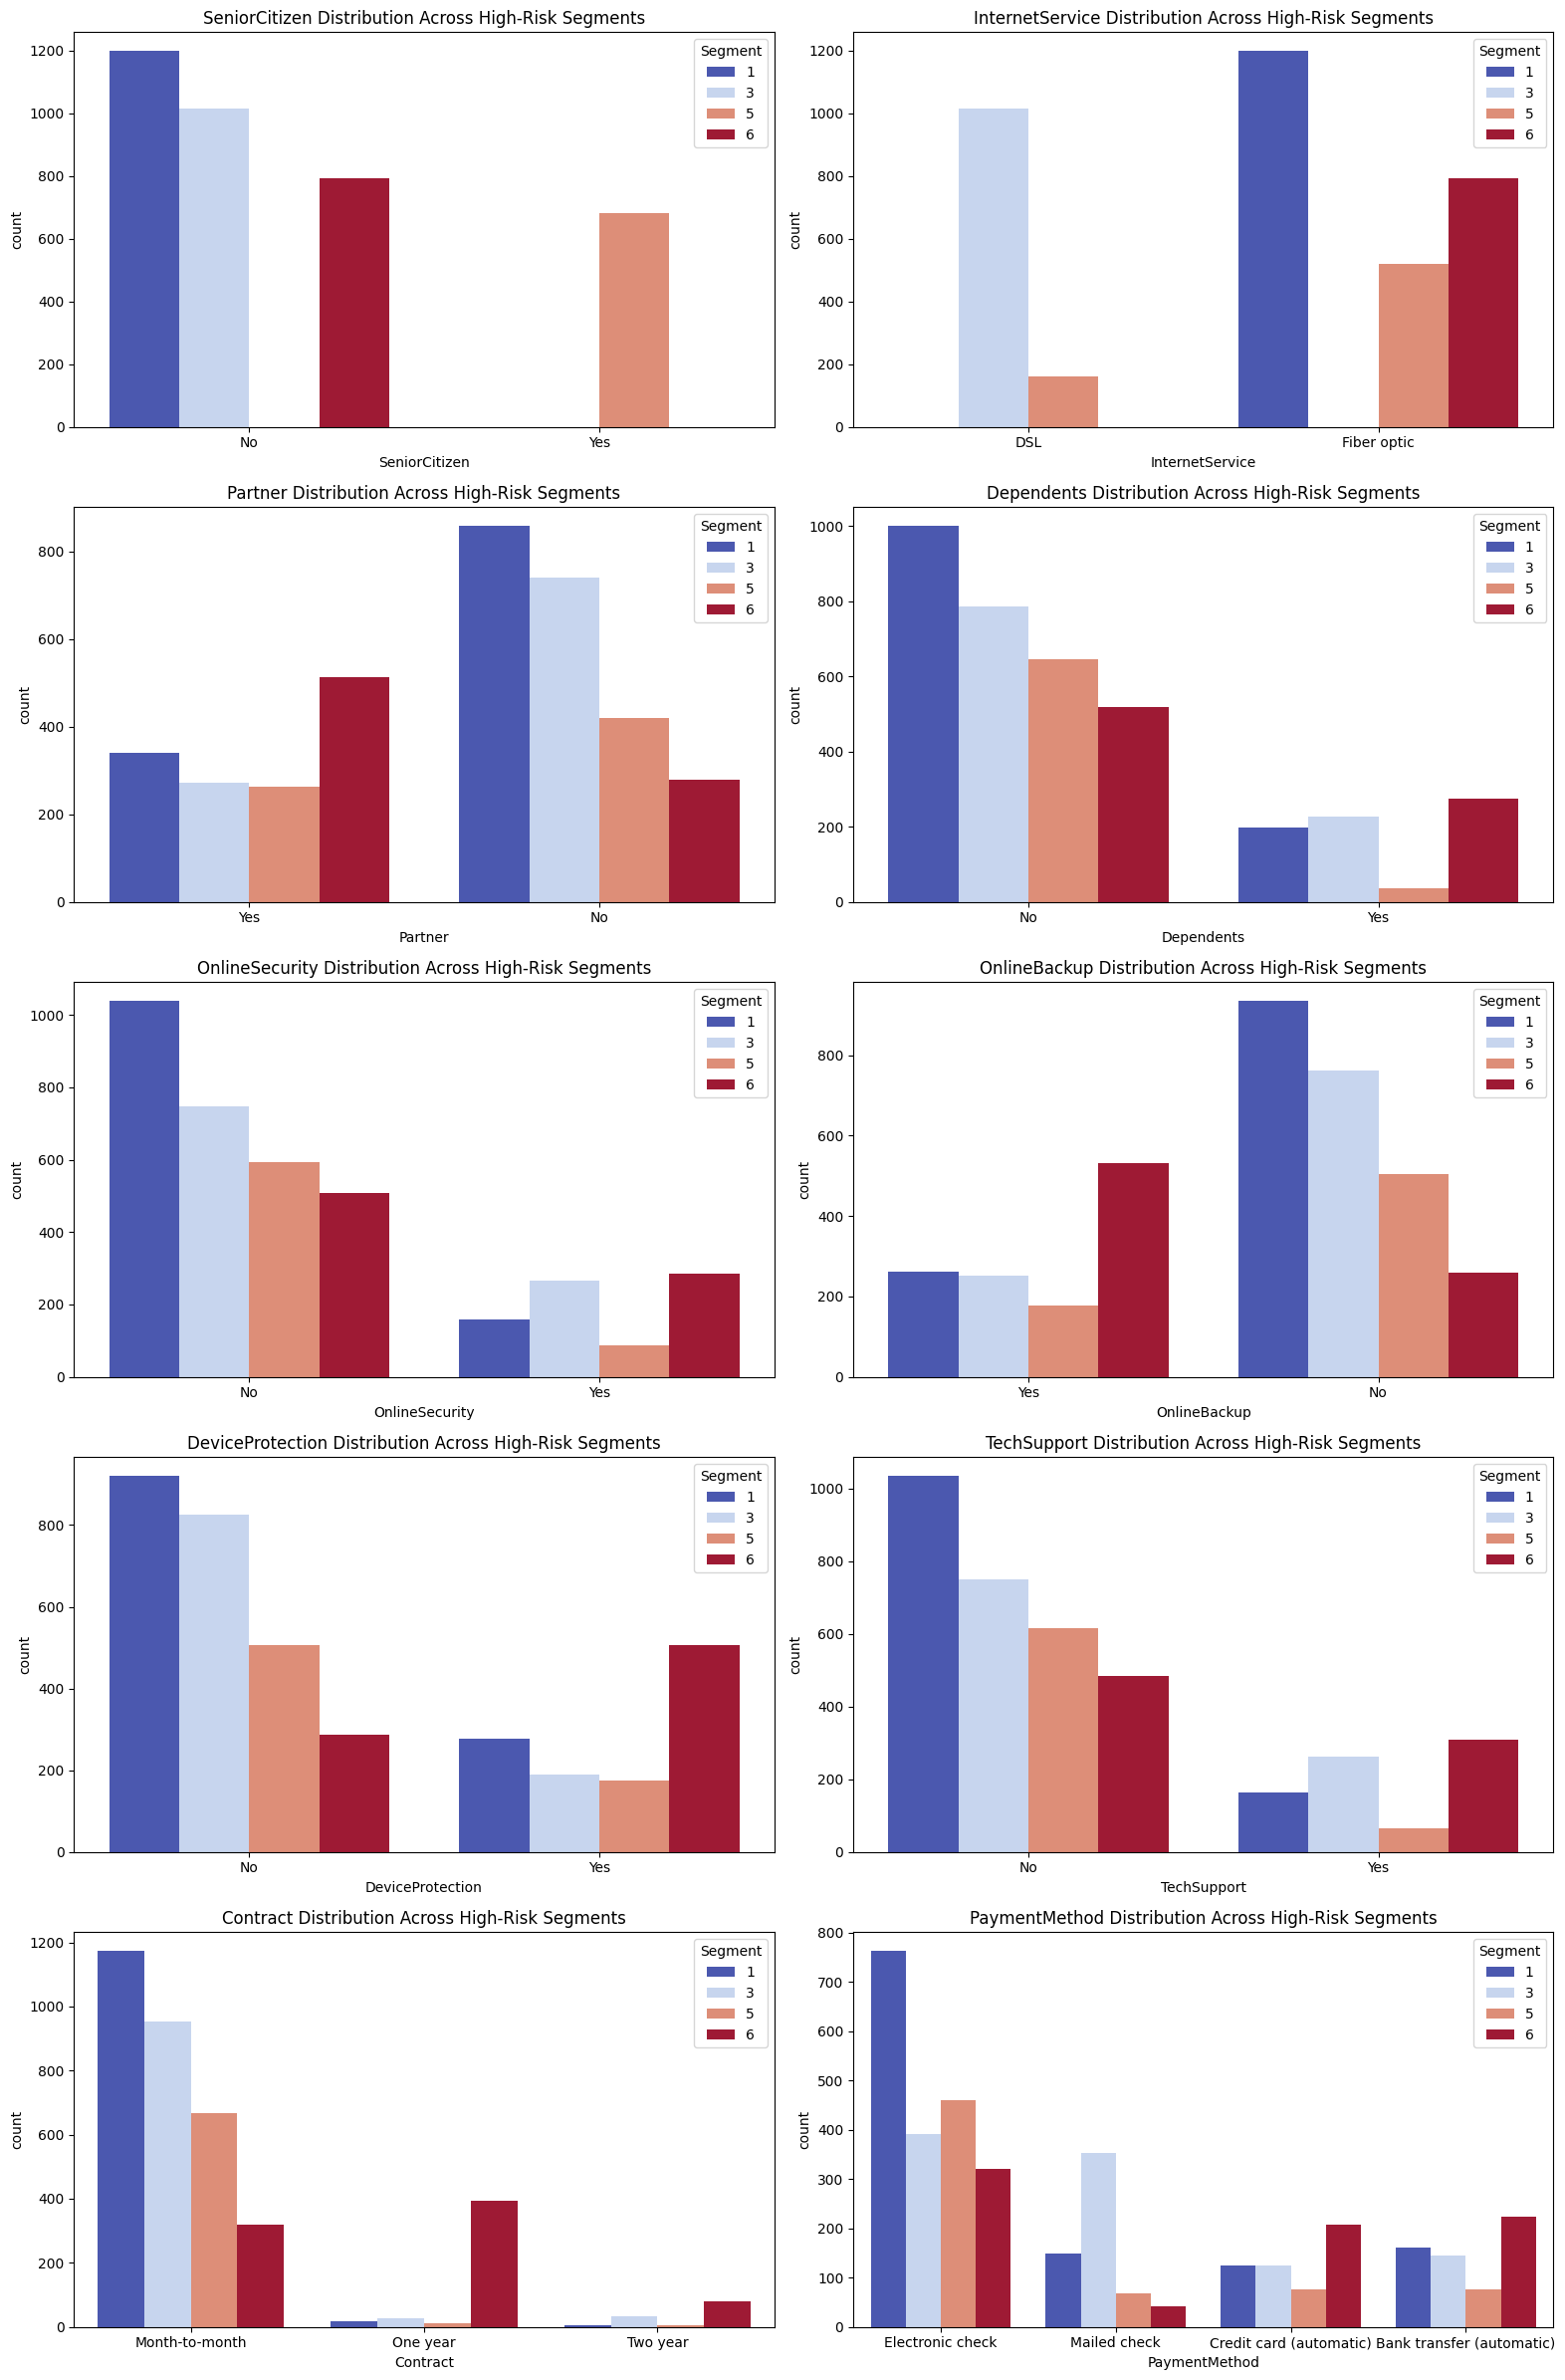

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Определение сегментов
all_segments = [0, 1, 2, 3, 4, 5, 6, 7, 8]
high_risk_segments = [1, 3, 5, 6]

# Список числовых переменных
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Создание подграфиков для числовых переменных
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Построение графиков для числовых переменных
for i, feature in enumerate(numerical_features):
    ax = sns.boxplot(x='Segment', y=feature, data=df[df['Segment'].isin(all_segments)], palette='coolwarm', ax=axes[i])
    median = df[feature].median()
    mean = df[feature].mean()
    ax.axhline(median, color='red', linestyle='--', label=f'Median: {median:.2f}')
    ax.axhline(mean, color='blue', linestyle='--', label=f'Mean: {mean:.2f}')
    ax.set_title(f'{feature} Distribution Across Segments with Median Line')
    ax.legend()

plt.tight_layout()
plt.show()

# Список категориальных переменных
categorical_features = ['SeniorCitizen', 'InternetService', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup',
                        'DeviceProtection', 'TechSupport', 'Contract', 'PaymentMethod']

# Создание подграфиков для категориальных переменных
fig, axes = plt.subplots(5, 2, figsize=(16, 24))

# Построение графиков для категориальных переменных
for i, feature in enumerate(categorical_features):
    row = i // 2
    col = i % 2
    sns.countplot(x=feature, hue='Segment', data=df[df['Segment'].isin(high_risk_segments)], palette='coolwarm', ax=axes[row, col])
    axes[row, col].set_title(f'{feature} Distribution Across High-Risk Segments')

plt.tight_layout()
plt.show()


In [19]:
# Анализ характеристик каждого кластера
cluster_profiles = df.groupby('Segment').mean(numeric_only=True)
print(cluster_profiles)

# Анализ уровня оттока в каждом кластере
segment_analysis = df.groupby('Segment')['Churn'].value_counts(normalize=True).unstack().fillna(0)
print(segment_analysis)


            tenure  MonthlyCharges  TotalCharges
Segment                                         
0        17.475761       20.579087    366.115276
1        13.399833       84.133472   1154.099416
2        63.182375       83.175765   5312.237576
3        13.191321       49.246548    661.320414
4        49.153239       21.772986   1084.345419
5        17.975073       76.405352   1405.336217
6        51.317781       97.991677   5057.450504
7        39.690909       62.001736   2473.477934
8        57.962779       93.339082   5425.047146
Churn          No       Yes
Segment                    
0        0.878241  0.121759
1        0.414858  0.585142
2        0.964504  0.035496
3        0.689349  0.310651
4        0.992101  0.007899
5        0.425220  0.574780
6        0.767970  0.232030
7        0.904132  0.095868
8        0.808933  0.191067


Мы использовали средние и медианные значения в числовых графиках, чтобы определить центральные значения и проверить, где находятся наши группы повышенного риска.

## 6) Корреляции

Давайте проверим **корреляции**:

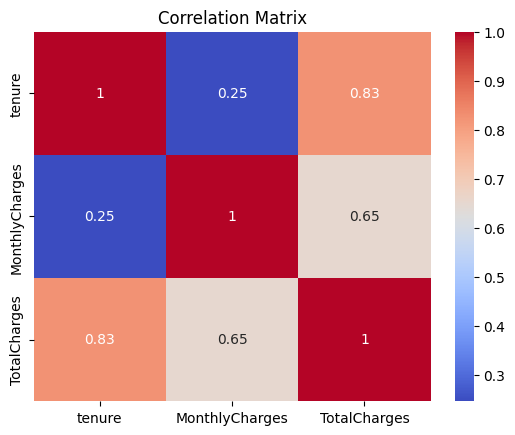

In [20]:
# Корреляционная матрица для числовых переменных
corr_matrix = df[numerical_vars].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [21]:
# Рассчитать VIF для проверки мультиколлинеарности
X = df[numerical_vars]
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

          Feature       VIF
0          tenure  6.332432
1  MonthlyCharges  3.361075
2    TotalCharges  8.079181


Мы видим, что **стаж пользования и общие расходы** имеют сильную корреляцию и мультиколлинеарность (VIF). Это означает, что мы можем объединить их в одну группу.

## 7) Интерпретация и рекомендации.

### **Ключевые выводы**.

Эти выводы и рекомендации обеспечивают стратегический подход к снижению оттока клиентов путем удовлетворения конкретных потребностей и болевых точек сегментов клиентов, подверженных риску.

1. **Демография и структура домохозяйства:**.
   - **Пожилые люди** демонстрируют **большую долю оттока** по сравнению с другими возрастными группами, вероятно, из-за проблем со сложностью обслуживания.
   - Клиенты, у которых **нет партнера или иждивенцев**, имеют **большую долю оттока**, возможно, из-за меньшей привязанности к услуге. <p> </p>

2. **Предложения услуг и продуктов:**.
   - Пользователи **DSL** и особенно **волоконной оптики** имеют **высокий процент оттока** по сравнению с клиентами, не имеющими интернет-услуг, что говорит о более высоких ожиданиях или неудовлетворенности услугами.
   - Отсутствие услуг поддержки** (например, отсутствие онлайн-резервного копирования, защиты устройств) коррелирует с **увеличением оттока**, указывая на то, что эти клиенты чувствуют себя менее защищенными. <p> </p>

3. **Предпочтения в отношении контрактов и биллинга:**.
   - **Месячные контракты** сильно связаны с **высоким уровнем оттока**, что отражает гибкость, позволяющую легко сменить поставщика услуг.
   - **Безбумажное выставление счетов** связано с **большим оттоком**, возможно, из-за воспринимаемой безличности или невовлеченности. <p> </p>

4. **Финансовые факторы:**.
   - **Небольшой срок пребывания в компании** связан с **большим оттоком**, хотя это может частично отражать естественное старение клиентской базы.
   - **Большие ежемесячные платежи** коррелируют с **большим оттоком**, что указывает на потенциальную неудовлетворенность воспринимаемой ценностью. <p> </p>

### **Профили клиентов с высоким риском**.

1. **Профиль 1** (кластер 1):
   - **Низкий стаж**, **низкая ежемесячная плата**, **пользовательDSL**, **без услуг поддержки**, **контракт «месяц в месяц »**.
   - Вывод:** Низкая вовлеченность и приверженность, высокий риск оттока. <p> </p>

2. **Профиль 2** (кластер 3):
   - **Средний стаж**, **высокая плата**, **пожилой человек**, **пользователь оптоволокна**, **без услуг поддержки**, **контракт на месяц**.
   - Вывод:** пожилые люди платят больше, но не чувствуют, что их ценят; высокий потенциал оттока. <p> </p>

3. **Профиль 3** (кластер 5):
   - **Низкий стаж**, **высокая плата**, **пользователь оптоволокна**, **без услуг поддержки**, **контракт на месяц**.
   - Вывод:** Быстрый отток, вероятно, из-за неудовлетворенности на ранних этапах. <p> </p>

4. **Профиль 4** (кластер 6):
   - **высокая продолжительность работы**, **высокие тарифы**, **много технических заявок**, **пользователь оптоволокна**, **имеет службу поддержки**.
   - Вывод:** Долгосрочные клиенты, расстроенные техническими проблемами; риск оттока, несмотря на лояльность. <p> </p>

### **Рекомендации**

1. **Целевые программы удержания:**.
   - **Пожилые люди:** Предлагайте индивидуальные услуги поддержки, включая упрощенные интерфейсы и персонализированное обслуживание клиентов.
   - **Одиночные клиенты:** Повышение вовлеченности с помощью персонализированных предложений и программ лояльности. <p> </p>

2. **Улучшение качества обслуживания:**.
   - **Интернет-пользователи:** Повышение надежности услуг и проактивное решение проблем.
   - **Продажа услуг поддержки:** Предлагайте пакетные скидки или пробные версии основных услуг поддержки. <p> </p>

3. **Стратегия заключения контрактов:**
   - **Месячные контракты:** Стимулируйте переход на долгосрочные контракты скидками или дополнительными преимуществами. <p> </p>

4. **Улучшение биллинга и вовлеченности:**
   - **Безбумажный биллинг:** Улучшение взаимодействия с клиентами, использующими безбумажный биллинг, возможно, путем интеграции вознаграждений или персонализированных обновлений.
   - **Высокие тарифы:** Обеспечьте дополнительную ценность за счет эксклюзивных предложений и премиальной поддержки, чтобы оправдать более высокие расходы. <p> </p>



## Bonus: Dashboard using Dash

In [ ]:
pip install dash

In [ ]:
pip install dash-bootstrap-components

In [24]:
import dash
import dash_bootstrap_components as dbc
import plotly.express as px
from dash import dcc, html

In [25]:
# Generate key statistics
churn_rate = df['Churn'].value_counts(normalize=True).get('Yes') * 100
total_customers = df['customerID'].nunique()
senior_citizen_churn_rate = df[df['SeniorCitizen'] == 'Yes']['Churn'].value_counts(normalize=True).get('Yes') * 100

# Custom colors for churn plots
churn_colors = {'Yes': '#F08080', 'No': '#90EE90'}

# Dropdown options
gender_options = [{'label': gender, 'value': gender} for gender in df['gender'].unique()]
payment_method_options = [{'label': method, 'value': method} for method in df['PaymentMethod'].unique()]

# Filtering based on dropdowns
def filter_data(gender, payment_method):
    filtered_df = df.copy()
    if gender:
        filtered_df = filtered_df[filtered_df['gender'] == gender]
    if payment_method:
        filtered_df = filtered_df[filtered_df['PaymentMethod'] == payment_method]
    return filtered_df

# App layout
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = dbc.Container([
    dbc.Row([
        dbc.Col(html.H1("Customer Churn Dashboard"), width=12)
    ]),

    # Dropdown filters
    dbc.Row([
        dbc.Col([
            dbc.Label("Select Gender"),
            dcc.Dropdown(id='gender-dropdown', options=gender_options, placeholder="All Genders")
        ], width=6),

        dbc.Col([
            dbc.Label("Select Payment Method"),
            dcc.Dropdown(id='payment-dropdown', options=payment_method_options, placeholder="All Payment Methods")
        ], width=6)
    ], className="mb-4"),

        # Key Statistics Cards
    dbc.Row([
        dbc.Col(dbc.Card([
            dbc.CardBody([
                html.H5("Total Customers", className="card-title"),
                html.P(f"{total_customers}", className="card-text"),
            ])
        ], color="#AEC6CF", inverse=True), width=4),

        dbc.Col(dbc.Card([
            dbc.CardBody([
                html.H5("Overall Churn Rate", className="card-title"),
                html.P(f"{churn_rate:.2f}%", className="card-text"),
            ])
        ], color="#9370DB", inverse=True), width=4),

        dbc.Col(dbc.Card([
            dbc.CardBody([
                html.H5("Senior Citizen Churn Rate", className="card-title"),
                html.P(f"{senior_citizen_churn_rate:.2f}%", className="card-text"),
            ])
        ], color="#FFB6C1", inverse=True), width=4)
    ], className="mb-4"),

    # Visualizations
    dbc.Row([
        dbc.Col(dcc.Graph(id='churn-overview'), width=4),
        dbc.Col(dcc.Graph(id='churn-by-senior'), width=8)
    ]),
    dbc.Row([
        dbc.Col(dcc.Graph(id='churn-by-contract'), width=6),
        dbc.Col(dcc.Graph(id='churn-by-internet'), width=6)
    ]),
    dbc.Row([
        dbc.Col(dcc.Graph(id='churn-by-tenure'), width=6),
        dbc.Col(dcc.Graph(id='churn-by-charges'), width=6)
    ]),

    # # High-Risk Customer Profiles
    # dbc.Row([
    #     dbc.Col(html.H2("High-Risk Customer Profiles"), width=12)
    # ]),
    # dbc.Row([
    #     dbc.Col(html.P([ html.Strong("Type 1:"), " Low tenure, low monthly charges, DSL user, no support services, month-to-month contract. High risk of churn."]), width=12),
    #     dbc.Col(html.P([ html.Strong("Type 2:")," Average tenure, higher charges, senior citizen, fiber optic user, no support services, month-to-month contract. High churn potential."]), width=12),
    #     dbc.Col(html.P([ html.Strong("Type 3:")," Low tenure, high charges, fiber optic user, no support services, month-to-month contract. Likely to churn early."]), width=12),
    #     dbc.Col(html.P([ html.Strong("Type 4:")," High tenure, high charges, many tech tickets, fiber optic user, has support services. Risk of churn despite loyalty."]), width=12)
    # ]),

    # # Recommendations
    # dbc.Row([
    #     dbc.Col(html.H2("Recommendations"), width=12)
    # ]),
    # dbc.Row([
    #     dbc.Col(html.Ul([
    #         html.Li([html.Strong("Targeted Retention Programs:"), " Develop specific retention strategies for senior citizens and single customers."]),
    #         html.Li([html.Strong("Service Quality Improvement:"), " Enhance reliability and proactively address service issues, especially for internet users."]),
    #         html.Li([html.Strong("Contract Strategy:"), " Encourage customers on month-to-month contracts to switch to longer-term contracts with incentives."]),
    #         html.Li([html.Strong("Billing and Engagement Enhancements:"), " Improve engagement for customers using paperless billing, potentially adding rewards."]),
    #         html.Li([html.Strong("Proactive Issue Resolution:"), " Offer priority support for customers with frequent technical issues to prevent churn."]),
    #     ]), width=12)
    # ])
], fluid=True)

# Update graphs based on selected filters
@app.callback(
    [dash.dependencies.Output('churn-overview', 'figure'),
     dash.dependencies.Output('churn-by-senior', 'figure'),
     dash.dependencies.Output('churn-by-contract', 'figure'),
     dash.dependencies.Output('churn-by-internet', 'figure'),
     dash.dependencies.Output('churn-by-tenure', 'figure'),
     dash.dependencies.Output('churn-by-charges', 'figure')],
    [dash.dependencies.Input('gender-dropdown', 'value'),
     dash.dependencies.Input('payment-dropdown', 'value')]
)
def update_graphs(selected_gender, selected_payment_method):
    filtered_df = filter_data(selected_gender, selected_payment_method)

    # Visualizations
    fig_churn_overview = px.pie(filtered_df, names='Churn', title='Overall Churn Rate', color='Churn', color_discrete_map=churn_colors)
    fig_churn_by_senior = px.bar(filtered_df.groupby(['SeniorCitizen', 'Churn']).size().reset_index(name='Count'),
                                 x='SeniorCitizen', y='Count', color='Churn',
                                 title='Churn by Senior Citizen Status',
                                 labels={'SeniorCitizen': 'Senior Citizen', 'Count': 'Customer Count'},
                                 barmode='group', color_discrete_map=churn_colors)
    fig_churn_by_contract = px.bar(filtered_df.groupby(['Contract', 'Churn']).size().reset_index(name='Count'),
                                   x='Contract', y='Count', color='Churn',
                                   title='Churn by Contract Type',
                                   labels={'Contract': 'Contract Type', 'Count': 'Customer Count'},
                                   barmode='group', color_discrete_map=churn_colors)
    fig_churn_by_internet = px.bar(filtered_df.groupby(['InternetService', 'Churn']).size().reset_index(name='Count'),
                                   x='InternetService', y='Count', color='Churn',
                                   title='Churn by Internet Service Type',
                                   labels={'InternetService': 'Internet Service Type', 'Count': 'Customer Count'},
                                   barmode='group', color_discrete_map=churn_colors)
    fig_churn_by_tenure = px.box(filtered_df, x='Churn', y='tenure', color='Churn',
                                 title='Distribution of Tenure by Churn',
                                 labels={'tenure': 'Tenure (Months)', 'Churn': 'Churn'},
                                 color_discrete_map=churn_colors, points="all")
    fig_churn_by_charges = px.scatter(filtered_df, x='MonthlyCharges', y='TotalCharges', color='Churn',
                                      title='Monthly Charges vs. Total Charges by Churn',
                                      labels={'MonthlyCharges': 'Monthly Charges', 'TotalCharges': 'Total Charges'},
                                      color_discrete_map=churn_colors)

    return fig_churn_overview, fig_churn_by_senior, fig_churn_by_contract, fig_churn_by_internet, fig_churn_by_tenure, fig_churn_by_charges

if __name__ == '__main__':
    app.run_server(debug=True)

Профили клиентов с высоким риском
Тип 1: Низкий срок, низкие ежемесячные платежи, пользователь DSL, без услуг поддержки, помесячный контракт. Высокий риск оттока.

Тип 2: Средний срок, высокие платежи, пожилой клиент, пользователь оптоволокна, без услуг поддержки, помесячный контракт. Высокий потенциал оттока.

Тип 3: Низкий срок, высокие платежи, пользователь оптоволокна, без услуг поддержки, помесячный контракт. Вероятность раннего оттока.

Тип 4: Высокий срок, высокие платежи, много технических заявок, пользователь оптоволокна, есть услуги поддержки. Риск оттока несмотря на лояльность.

Рекомендации
Целевые программы удержания: Разработайте конкретные стратегии удержания для пожилых людей и одиноких клиентов.

Улучшение качества обслуживания: Повышайте надежность и проактивно решайте проблемы с обслуживанием, особенно для пользователей интернета.

Стратегия контрактов: Поощряйте клиентов с помесячными контрактами переходить на долгосрочные контракты с помощью стимулов.

Улучшение выставления счетов и взаимодействия: Улучшайте взаимодействие с клиентами, использующими безбумажное выставление счетов, возможно, добавляя вознаграждения.

Проактивное решение проблем: Предлагайте приоритетную поддержку клиентам с частыми техническими проблемами, чтобы предотвратить отток.